# Comparison of Last Round AF Subtraction vs. Combined First and Last

**Question:** How should blank images be used for AF subtraction? The last round qunched image can be used, to minimize over subtraction. Or, based on the round, a combination of round zero and last round ("scaled") may be used.

**Samples:** 
- Tissue ID 44290: HER2+/ER+ breast cancer. Section 146 stained with a 8 round cyclic IF protocol, blank images collected at round 0 (after a pre-quenching step) and after R8 stain and quench.

**Method**: AF subtraction performed with two conditions (above), and single cell intensity features were extracted from each image set and analyzed.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import copy
import seaborn as sns
matplotlib.rcParams.update({'font.size': 22})
import numpy as np
import json

# AF Subtraction Scaled vs R8Q Analysis Steps

1. threshold and annotate subtracted data R8Q to get positive ground truth

2. Compare to positve calls when same thresholds are applied to the scaled AF subtracted images

3. calculate F1: TP/TP + 1/2(FP + FN)


## Load Data


In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation'

In [3]:
#based on R8Q subtraction
df_pos = pd.read_csv(
        f'{codedir}/Data/20200826_BC44290-146_ManualPositive.csv',
        index_col=0
    )
#df_pos.head()

In [4]:
# AF subtracted images version
df_pos_scale = pd.read_csv(
        f'{codedir}/Data/20200911_BC44290-146_ManualPositive.csv',
        index_col=0
    )

In [5]:
#channel metadata
df_t = pd.read_csv(f'{codedir}/Metadata/44290-146/metadata_BC44290-146_RoundsCyclesTable_ExposureTimes.csv',
                  index_col=0)

In [6]:
df_edge = pd.read_csv(f'{codedir}/Data/features_BC44290-146_EdgeCells308pixels_CentroidXY.csv', index_col=0)
#drop edge cells
df_pos_scale = df_pos_scale[~df_pos_scale.index.isin(df_edge.index.tolist())]
df_pos = df_pos[~df_pos.index.isin(df_edge.index.tolist())]

## False Postives

These are eay to calculate across entire tissue, by using a threshold on the AF images (Round 0) to determine bright autofluorescent cells.

In [7]:
#cell types

#define AF
ls_af = ['R0c2_Nuclei','R0c3_Nuclei','R0c4_Nuclei','R0c2_Ring','R0c3_Ring','R0c4_Ring'] 
df_pos['AF'] = df_pos.loc[:,ls_af].sum(axis=1)>=1 


In [8]:
#Whole tissue false positive
ls_marker = df_t[(df_t.colors!='c5') & ~df_t.rounds.isin(['R0','R8Q'])& ~df_t.index.isin(['CD20'])].index
for s_marker in ls_marker:
    if df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')].shape[1] > 0:
        #print(s_marker)
        df_marker = df_pos.loc[:,df_pos.columns.str.contains(f'{s_marker}_')]
        df_scale = df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')]
        df_fp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==True)]
        df_tp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_t.loc[s_marker,'R8Q_FP'] = len(df_fp)
        df_fn = df_scale[(df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_tp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_fp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_pos.loc[:,'AF']==True)]
        df_t.loc[s_marker,'Scaled_FP'] = len(df_fp_scale)
        #these may be fales neg/ or true neg. need to annotate sinlge cells in Napari
        df_t.loc[s_marker,'Scaled_FN'] = len(df_fn)
        df_pos[f'{s_marker}_FalseNegative'] = ((df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False))
        f1_baseline = df_tp.sum()[0]/(df_tp.sum()[0] + 0.5*(len(df_fp)))
        f1_scale = df_tp_scale.sum()[0]/(df_tp_scale.sum()[0] + 0.5*(len(df_fp_scale) + len(df_fn)))
        #print(f1_baseline)
        #print(f1_scale)
    

/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [9]:
df_t['Diff'] = df_t.R8Q_FP - df_t.Scaled_FP

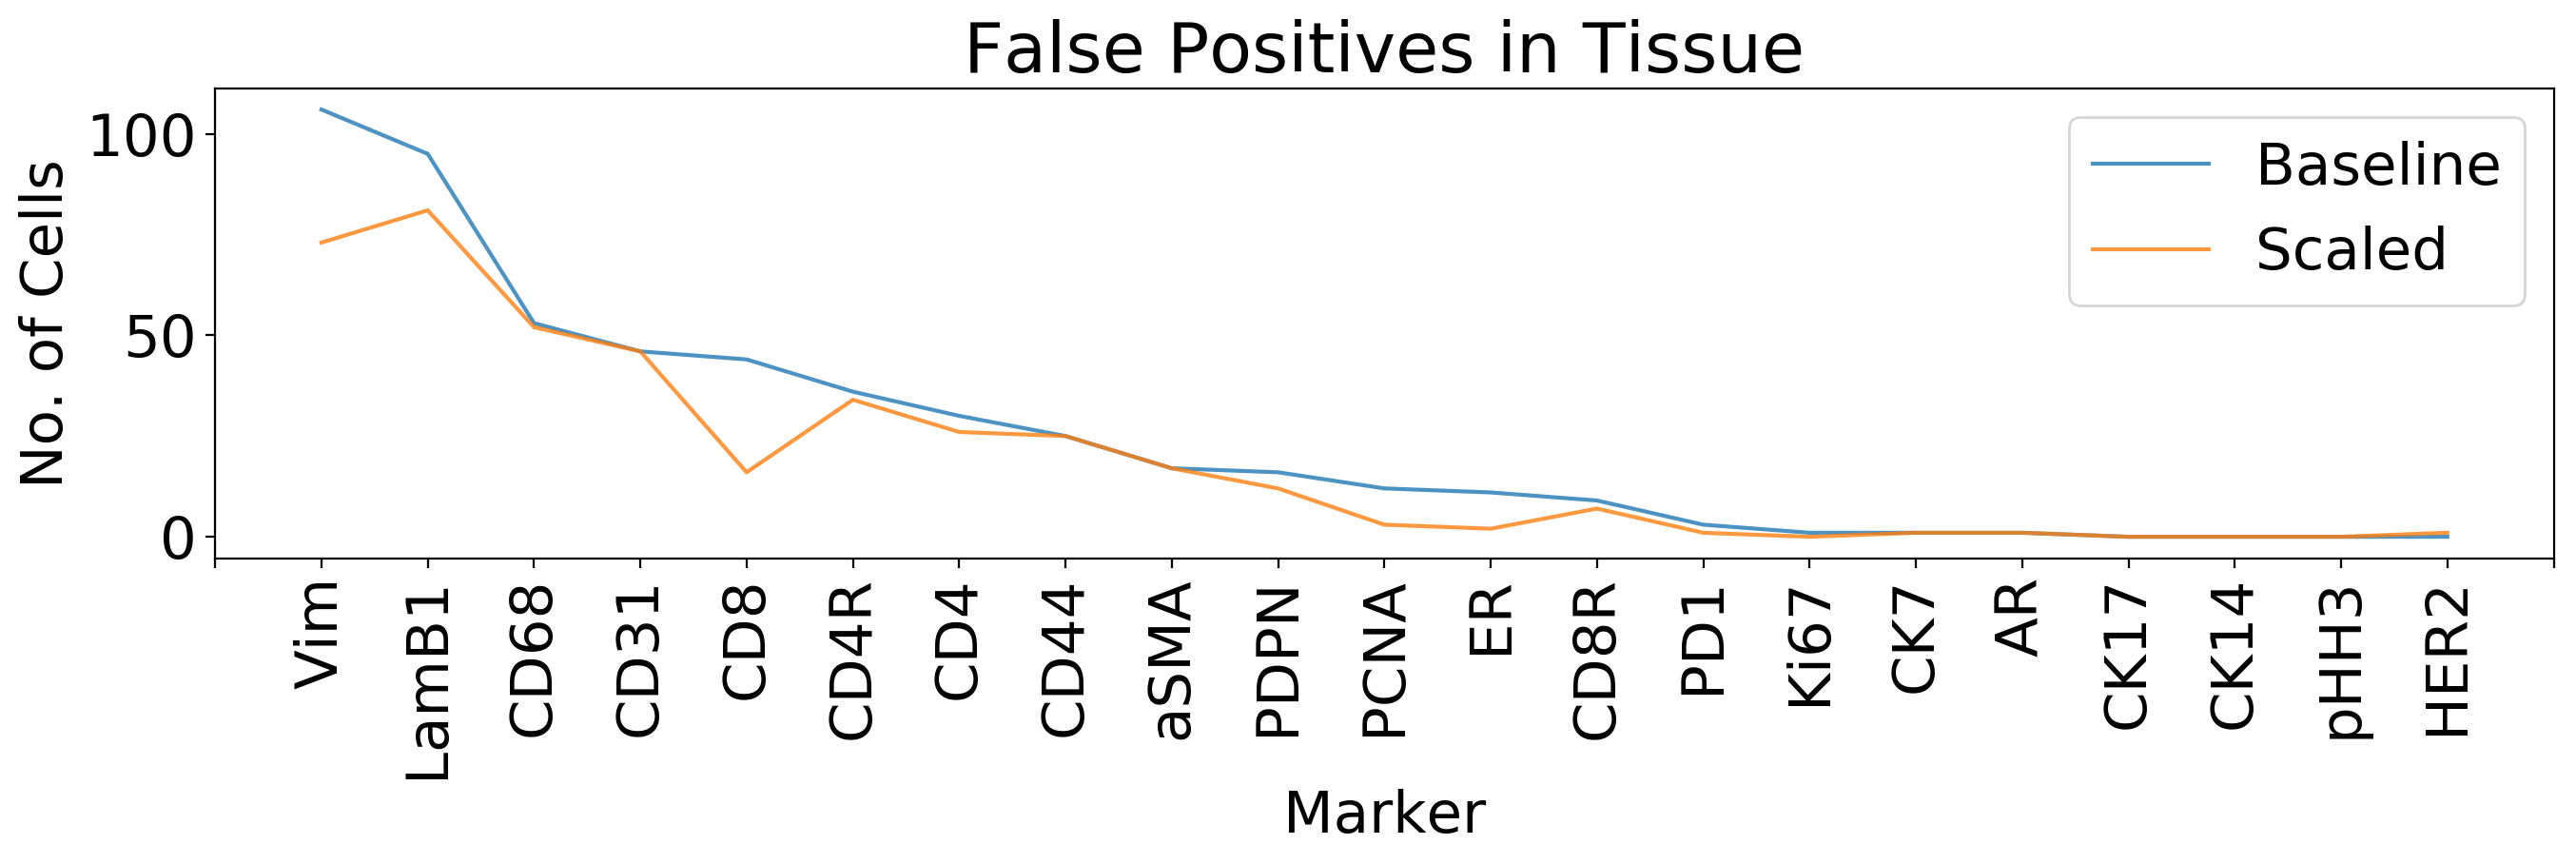

In [10]:
#plot false positives
ls_labels = df_t.loc[ls_marker,:].sort_values('R8Q_FP',ascending=False).loc[:,['R8Q_FP','Scaled_FP']].dropna().index.tolist()
ls_labels.insert(0,'')
fig, ax = plt.subplots(figsize=(14,5),dpi=200)
df_t.loc[ls_marker,:].sort_values('R8Q_FP',ascending=False).loc[:,['R8Q_FP','Scaled_FP']].dropna().plot(ax=ax,rot=90,alpha=0.8)
ax.xaxis.set_major_locator(plt.MaxNLocator(22))
ax.set_xticklabels(ls_labels)
ax.set_title('False Positives in Tissue')
ax.set_ylabel('No. of Cells')
ax.set_xlabel('Marker')
ax.legend(['Baseline','Scaled'])
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290-146/ScaledvsR8Q_44290_lineplot.png')

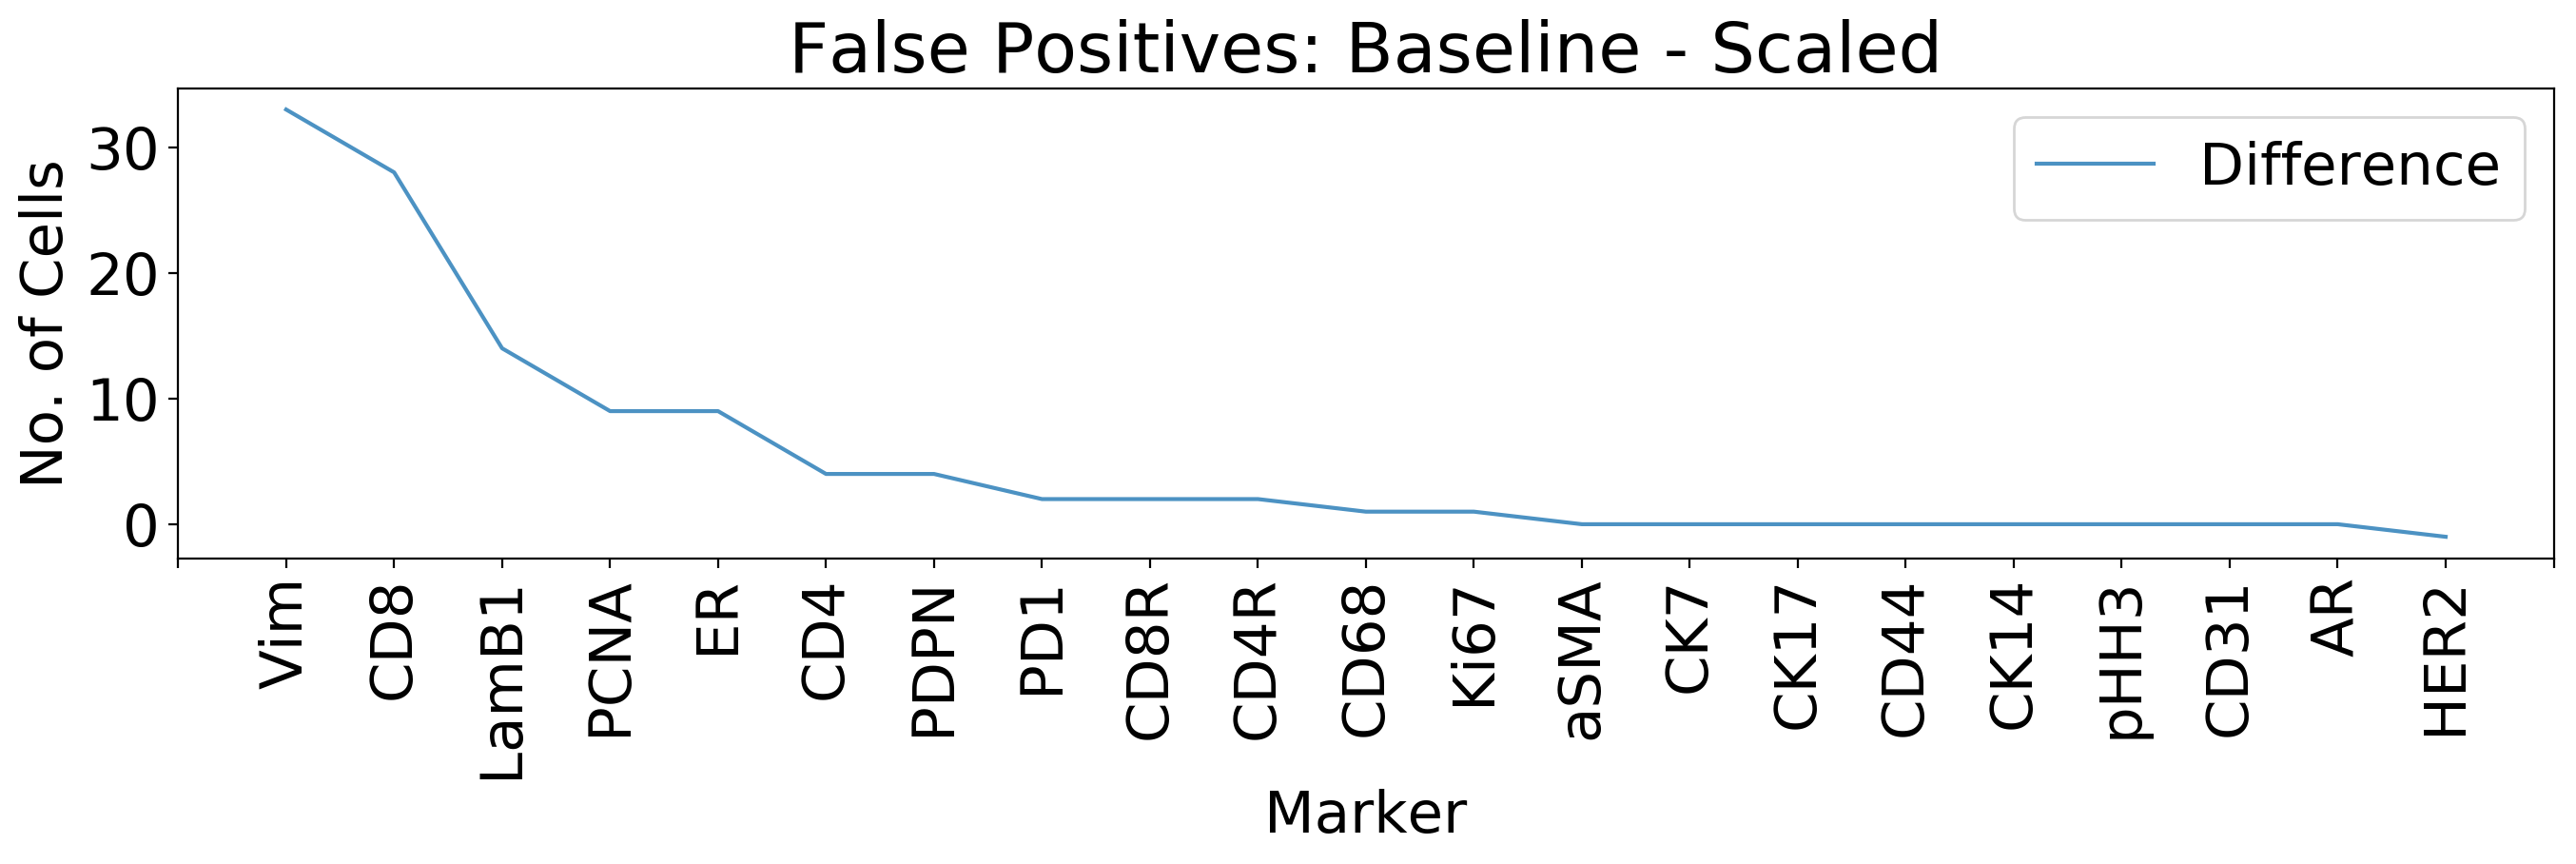

In [11]:
#plot false positives
ls_labels = df_t.loc[ls_marker,'Diff'].sort_values(ascending=False).dropna().index.tolist()
ls_labels.insert(0,'')
fig, ax = plt.subplots(figsize=(14,5),dpi=200)
df_t.loc[ls_marker,'Diff'].sort_values(ascending=False).dropna().plot(ax=ax,rot=90,alpha=0.8)
ax.xaxis.set_major_locator(plt.MaxNLocator(22))
ax.set_xticklabels(ls_labels)
ax.set_title('False Positives: Baseline - Scaled')
ax.set_ylabel('No. of Cells')
ax.set_xlabel('Marker')
ax.legend(['Difference'])
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290-146/ScaledvsR8Q_diff_44290_lineplot.png')

# Single Cell Annotation of False Negatives

Calling false negatives requires comparing images and labels in Napari, here. Only 2000 X 2000 pixel ROIs were analyzed

In [12]:
#save potential false negatives for annotation
#df_pos.to_csv(f'{codedir}/Data/20200911_BC44290-146_PositiveNegative.csv')

In [13]:
#load annotated (in Napari)
dd_result = {}
for s_crop in ['x2000y5000','x2000y7000','x1800y9000']:
    with open(f'{codedir}/Data/TrueNegatives_CellIDs_44290-146_scaledAF_{s_crop}.json','r') as f:
        d_result = json.load(f)
    dd_result.update({s_crop:d_result})

In [14]:
d_index = {}
for s_crop in ['x2000y5000','x2000y7000','x1800y9000']:
    idx_x = df_pos[(df_pos.DAPI_X > int(s_crop.split('x')[1].split('y')[0])) & (df_pos.DAPI_X < (2000 + int(s_crop.split('x')[1].split('y')[0])))].index
    idx_y =df_pos[(df_pos.DAPI_Y > int(s_crop.split('y')[1])) & (df_pos.DAPI_Y < (2000 + int(s_crop.split('y')[1])))].index
    index_crop = idx_x.intersection(idx_y)
    d_index.update({s_crop:index_crop})

In [21]:
#calculate F1 in annotated crop
df_result = pd.DataFrame()
ls_marker = df_t[(df_t.colors!='c5') & ~df_t.rounds.isin(['R0','R8Q'])& ~df_t.index.isin(['LamB1','Vim','CD20'])].index
for s_marker in ls_marker:
    for s_crop, d_result in dd_result.items():
        index_crop = d_index[s_crop]
        if df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')].shape[1] > 0:
            df_marker = df_pos.loc[index_crop,df_pos.columns.str.contains(f'{s_marker}_')]
            df_scale = df_pos_scale.loc[index_crop,df_pos_scale.columns.str.contains(f'{s_marker}_')]
            df_fp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==True)]
            df_tp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_t.loc[s_marker,'R8Q_FP'] = len(df_fp)
            df_fn = df_scale[(df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_tp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_fp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==True)]
            df_t.loc[s_marker,'Scaled_FP'] = len(df_fp_scale)
            #these may be fales neg/ or true neg. need to annotate sinlge cells in Napari
            if len(set(d_result.keys()).intersection(set([s_marker.split('_')[0]]))) > 0:
                print(s_marker)
                i_fn = len(d_result[s_marker.split('_')[0]])
            else:
                i_fn = 0
            df_t.loc[s_marker,'R8Q_FN'] = i_fn
            df_t.loc[s_marker,'Scaled_FN'] = len(df_fn) - i_fn
            # calculate F1
            f1_baseline = df_tp.sum()[0]/(df_tp.sum()[0] + 0.5*(len(df_fp) + i_fn))
            f1_scale = df_tp_scale.sum()[0]/(df_tp_scale.sum()[0] + 0.5*(len(df_fp_scale) + len(df_fn) - i_fn))
            print(f1_baseline)
            print(f1_scale)
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Baseline'] = f1_baseline
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Scaled'] = f1_scale
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Marker'] = s_marker.split('_')[0]


0.9995448338643604
0.9995448338643604
0.9970743124634289
0.9988276670574443
CD8
0.9926806953339433
0.9976969138645785
CD4
0.9995517705064993
0.9993262968785088
CD4
0.9983372131692717
0.9990003332222592
CD4
0.9962779156327544
0.9968944099378882
1.0
1.0
0.9932885906040269
1.0
0.9772727272727273
0.9942196531791907
1.0
1.0
1.0
1.0
1.0
1.0
ER
0.9767441860465116
1.0
0.970873786407767
1.0
0.9761904761904762
0.9815950920245399
1.0
1.0
1.0
1.0
1.0
1.0
nan
nan
nan
nan


/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


nan
nan
0.9997873697639804
0.9997873697639804
0.9991876523151909
0.9991876523151909
0.9979455572675912
0.9979455572675912
1.0
1.0
1.0
1.0
1.0
1.0
PD1
0.9902912621359223
1.0
1.0
0.9940119760479041
0.991304347826087
0.9912280701754386
0.9523809523809523
0.9523809523809523
1.0
1.0
0.9912280701754386
0.9912280701754386
CD68
0.9989528795811519
1.0
CD68
0.9898373983739838
0.9938271604938271
CD68
0.9719934102141681
0.9764309764309764
1.0
1.0
1.0
1.0
1.0
1.0
nan
nan


/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


1.0
1.0
nan
nan
0.999213217938631
0.999213217938631
0.9902152641878669
0.9960629921259843
0.9861111111111112
1.0
0.9753086419753086
0.9753086419753086
CD31
0.9880478087649402
0.9919354838709677
CD31
0.9728395061728395
0.9751243781094527
0.9996061441512406
0.9996061441512406
CD8R
0.9979445015416238
0.9979360165118679
CD8R
0.9972776769509982
0.9981718464351006
1.0
1.0
CD4R
0.9978172747115684
0.9990622069396686
0.9966717095310136
0.9966717095310136
1.0
1.0
1.0
0.989010989010989
1.0
1.0


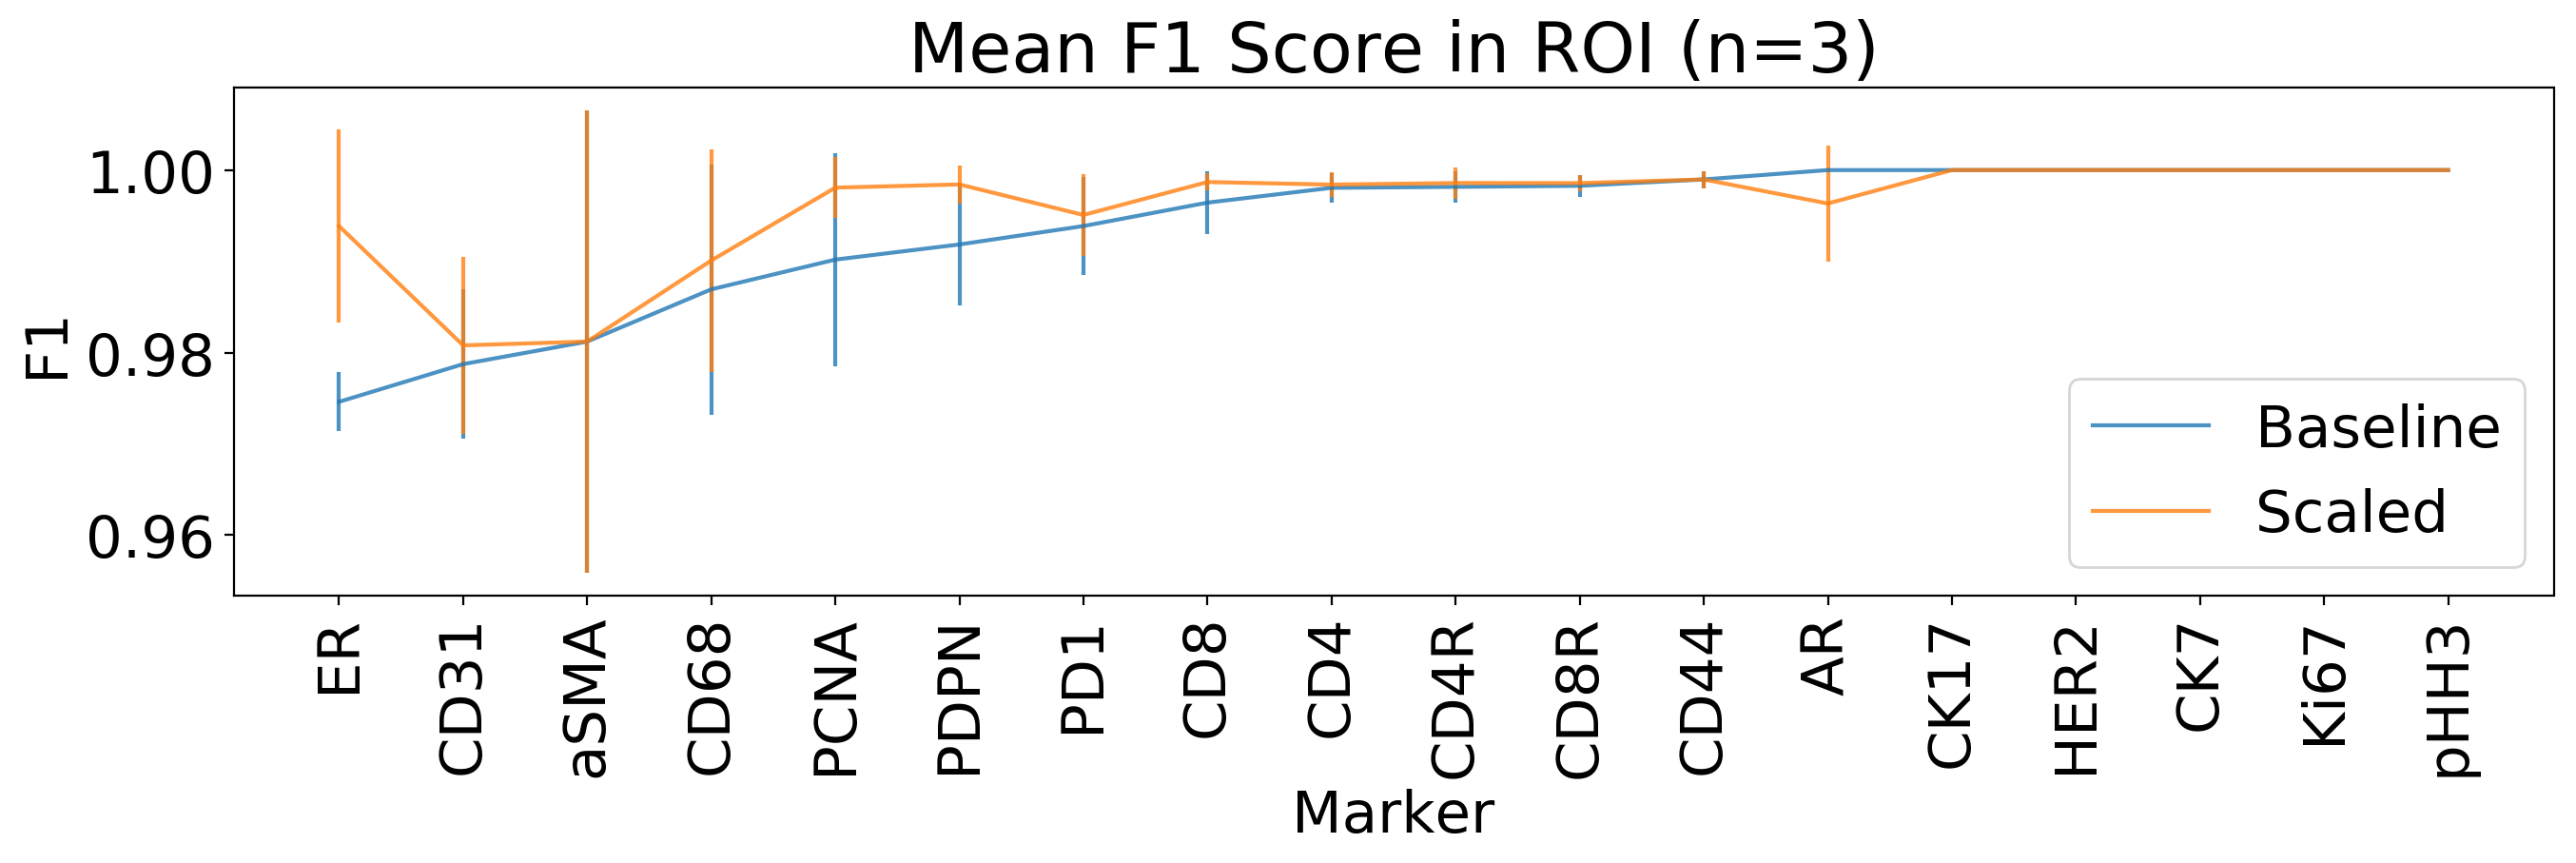

In [25]:
#plot false positives
ls_labels = df_result.groupby('Marker').mean().sort_values('Baseline').index.tolist()
df_std = df_result.groupby('Marker').std().loc[ls_labels]
ls_labels.insert(0,'')
fig, ax = plt.subplots(figsize=(14,5),dpi=200)
df_result.groupby('Marker').mean().sort_values('Baseline').plot(ax=ax,rot=90,alpha=0.8,yerr=df_std)
ax.xaxis.set_major_locator(plt.MaxNLocator(21))
ax.set_xticklabels(ls_labels)
ax.set_title('Mean F1 Score in ROI (n=3)')
ax.set_ylabel('F1')
ax.set_xlabel('Marker')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290-146/ScaledvsR8Q_F1_44290_lineplot.png')


In [23]:
#total cells in 3 rois
i_result = 0
for s_crop, d_result in dd_result.items():
    index_crop = d_index[s_crop]
    i_result = i_result + len(index_crop)
print(i_result)

13160


In [24]:
len(ls_labels)

20